In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, random

In [36]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

fatal: destination path 'Image-Classification-CNN-and-VGG' already exists and is not an empty directory.


In [37]:
print(tf.__version__)

2.4.0


#Labelling Data

In [38]:
IMAGE_HEIGNT=128
IMAGE_WIDTH=128
BATCH_SIZE=64

In [39]:
def get_pathframe(path):
  filenames=os.listdir(path)
  categories=[]
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category=='dog':
      categories.append(1)
    else:
      categories.append(0)
  
  df=pd.DataFrame({
      'filename':filenames,
      'category':categories,
      'paths':paths
  })
  return df

#Data Frame

In [40]:
df = get_pathframe('Image-Classification-CNN-and-VGG/dataset/dataset/')

In [41]:
df.tail(5)

,filename,category,paths
24995,cat.7296.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24996,cat.5475.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24997,dog.3377.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24998,dog.11828.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24999,dog.12143.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...


In [42]:
df.head()

,filename,category,paths
0,dog.12457.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
1,dog.6743.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
2,cat.9220.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
3,cat.7588.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
4,cat.6782.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...


#Image Loading

In [43]:
def load_and_preprocess_image(path):
  '''
  Load Each Image nad resize it to the desired shape / size
  '''
  image=tf.io.read_file(path)
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image,[IMAGE_WIDTH, IMAGE_HEIGNT])
  image/=255.0 # Normalize to [0,1] range
  return image

In [44]:
def convert_to_tensor(df):
  '''
  Convert each data and Labels to tensor
  '''
  path_ds=tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds=path_ds.map(load_and_preprocess_image)
  
  onehot_label=tf.cast(df['category'],tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)
  return image_ds,label_ds

#Train and Test Split

In [45]:
X,Y=convert_to_tensor(df)
print('Shape of X in data: ',X)
print('Shape of Y in data:', Y)

Shape of X in data:  <MapDataset shapes: (128, 128, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (), types: tf.int64>


In [46]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)
dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train)
print(dataset_test)


<BatchDataset shapes: ((64, 128, 128, 3), (64,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((64, 128, 128, 3), (64,)), types: (tf.float32, tf.int64)>


#Check Images

In [47]:
def plotImages(imagesls):
  fig, axes = plt.subplots(1,8,figsize=(40,40))
  axes=axes.flatten()
  for image, ax in zip(imagesls,axes):
    ax.imshow(image)
    ax.axis('off')

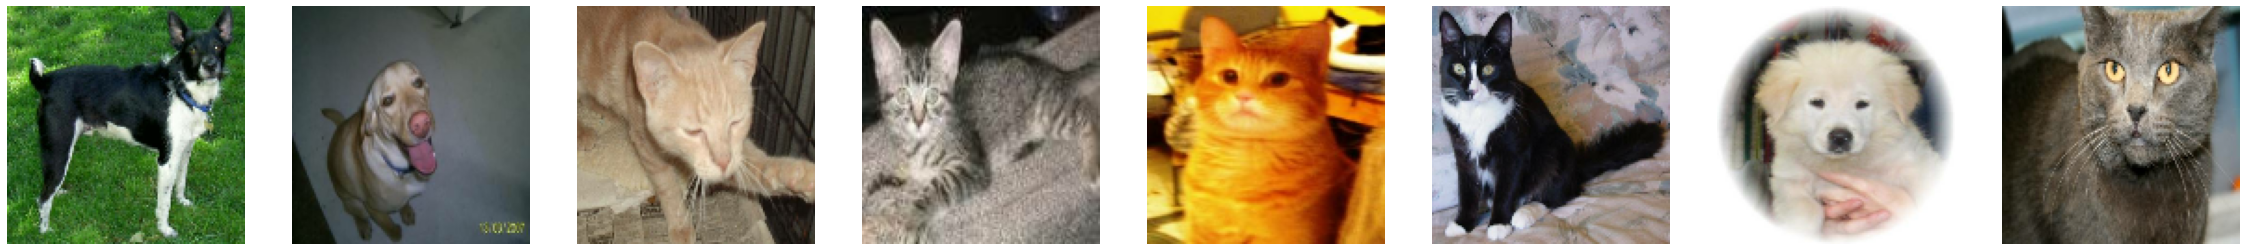

In [48]:
imagesls=[]
for n, image in enumerate(X.take(8)):
  imagesls.append(image)

plotImages(imagesls)

#CNN Architecture

In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGNT,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(512, (3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       5

#Add Dense Layers on Top

In [50]:
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       5

#train our Model

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
history = model.fit(dataset_train, epochs=20, validation_data=dataset_test)

Epoch 1/20
351/351 [==============================] - 69s 190ms/step - loss: 0.6693 - accuracy: 0.5846 - val_loss: 0.5157 - val_accuracy: 0.7404
Epoch 2/20
351/351 [==============================] - 69s 192ms/step - loss: 0.4584 - accuracy: 0.7860 - val_loss: 0.3796 - val_accuracy: 0.8289
Epoch 3/20
351/351 [==============================] - 69s 191ms/step - loss: 0.3626 - accuracy: 0.8392 - val_loss: 0.2963 - val_accuracy: 0.8674
Epoch 4/20
351/351 [==============================] - 70s 193ms/step - loss: 0.2973 - accuracy: 0.8716 - val_loss: 0.2530 - val_accuracy: 0.8994
Epoch 5/20
351/351 [==============================] - 69s 190ms/step - loss: 0.2406 - accuracy: 0.8992 - val_loss: 0.2324 - val_accuracy: 0.9067
Epoch 6/20
351/351 [==============================] - 69s 192ms/step - loss: 0.1867 - accuracy: 0.9232 - val_loss: 0.2137 - val_accuracy: 0.9199
Epoch 7/20
351/351 [==============================] - 68s 189ms/step - loss: 0.1443 - accuracy: 0.9434 - val_loss: 0.3376 - val_ac

#Visualizing Training Results

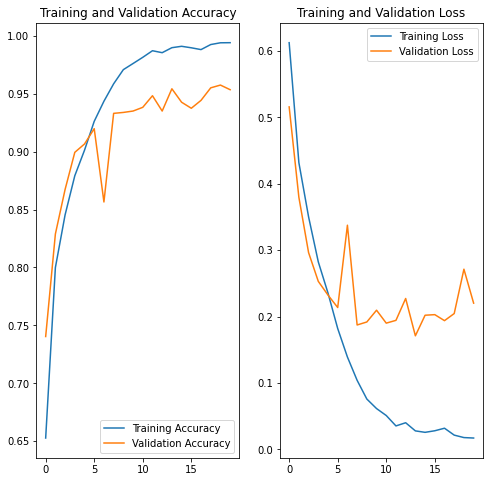

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#Test Our Model

In [54]:
predictions = model.predict(dataset_test)

In [55]:
score = tf.nn.softmax(predictions[0])

In [72]:
print(score)

tf.Tensor([1.], shape=(1,), dtype=float32)


#Confusion Matrix

In [74]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix